# This is a test notebook to check if spherical model is correct

Let's import libraries first and print versions used

In [7]:
import numpy as np
import pandas as pd
from math import cos, sin, pi
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from alive_progress import alive_bar

# import plotly.io as pio
# pio.renderers (in case it does not render a figure, check out the input/output renderers and set it to the right renderer (e.g. fig.show(renderer='firefox+jupyterlab'))

print('\n'.join(f'{m.__name__}=={m.__version__}' for m in globals().values() if getattr(m, '__version__', None)))

numpy==1.22.3
pandas==0.25.3


Now we can create recently derived spherical geometry case

In [8]:
"""
    d_sphere_P(r::Array{Cdouble,1},θ::Array{Cdouble,1},φ::Array{Cdouble,1},x0::Cdouble,y0::Cdouble,z0::Cdouble,μ0::Cdouble)
    In the spherical geometry, e.g. droplet, this function computes the distance from any
    point M:(r,θ,φ) in the sample to the surface in direction to some point P:(x0,y0,z0).
    Note: M is given in spherical coordinates and P in Cartesian coordinates.
    The geometry of the sample is so that Oy is the symmetry axis (along the droplet stream direction),
    Oz is along the photon beam and Ox is the remaining axis in the orthogonal basis.
    θ is taken between Oz and the project of M onto the plane xOz, φ between M and Oy, and r = √(x^2+y^2+z^2)
    μ0 is the radius of the cylinder
"""
def d_sphere_P(r, θ, φ, x0, y0, z0, μ0):
    dp = np.zeros((len(r), len(θ), len(φ)))
    dp_dict = {'r':[], 'θ':[], 'φ':[], 'dp':[]}
    
    with alive_bar(len(r)*len(θ)*len(φ), force_tty=True) as bar:
        for i, R in enumerate(r):
            for j, Ө in enumerate(θ):
                for k, Φ in enumerate(φ):
                    ## M coordinates from spherical to cartesian system
                    xm = R*cos(Ө)*sin(Φ)
                    ym = R*sin(Ө)*sin(Φ)
                    zm = R*cos(Φ)

                    ## compute all cos/sin
                    cosω = (x0-xm) / ((x0-xm)**2 + (y0-ym)**2)**.5
                    sinω = (y0-ym) / ((x0-xm)**2 + (y0-ym)**2)**.5
                    
                    cosβ = ((x0-xm)**2 + (y0-ym)**2)**.5 / ((x0-xm)**2 + (y0-ym)**2 + (z0-zm)**2)**.5
                    sinβ = (z0-zm) / ((x0-xm)**2 + (y0-ym)**2 + (z0-zm)**2)**.5
                    
                    cosα = sin(Φ) * cosβ * (
                        cos(Ө) * cosω + sin(Ө) * sinω) + cos(Φ) * sinβ

                    dp[i,j,k] =  (μ0**2 - R**2 * (1-cosα**2))**.5 - R * cosα

                    dp_dict['r'].append(R)
                    dp_dict['θ'].append(Ө)
                    dp_dict['φ'].append(Φ)
                    dp_dict['dp'].append(dp[i,j,k])
                    bar()
    return dp, pd.DataFrame(dp_dict)

Now let's generate a dataframe we are going to plot and check. For this we should generate a set of (r, θ, φ) points inside of the sphere/droplet and choose a point of location of the the detector. 

In [9]:
μ0 = 20.0   # radius
λe = 2.0e-3 # μ0; # EAL
L = 3 * μ0  # 

J = 10 # "resolution"
r = np.linspace(0.0, μ0, J) 
θ = np.linspace(0, 2*pi, J)
φ = np.linspace(0.0, pi, J)

# magic angle: atan(sqrt(2.0),1.0)
# near the analyzer
x0_near = 21.0*2.0**.5
y0_near = 0.0
z0_near = 21.0

## compute distances
DD, DDdf = d_sphere_P(r, θ , φ, x0_near, y0_near, z0_near, μ0)

DDdf.head(5) # check DataFrame

|████████████████████████████████████████| 1000/1000 [100%] in 0.0s (37104.94/s)                                        


,r,θ,φ,dp
0,0.0,0.0,0.000000,20.0
1,0.0,0.0,0.349066,20.0
2,0.0,0.0,0.698132,20.0
3,0.0,0.0,1.047198,20.0
4,0.0,0.0,1.396263,20.0


The plot is done as a scatter3D and it's interactive (each point is a small sphere with color depending on distance). This is time consuming solution, it is worth to invent some way to plot it like a surface.

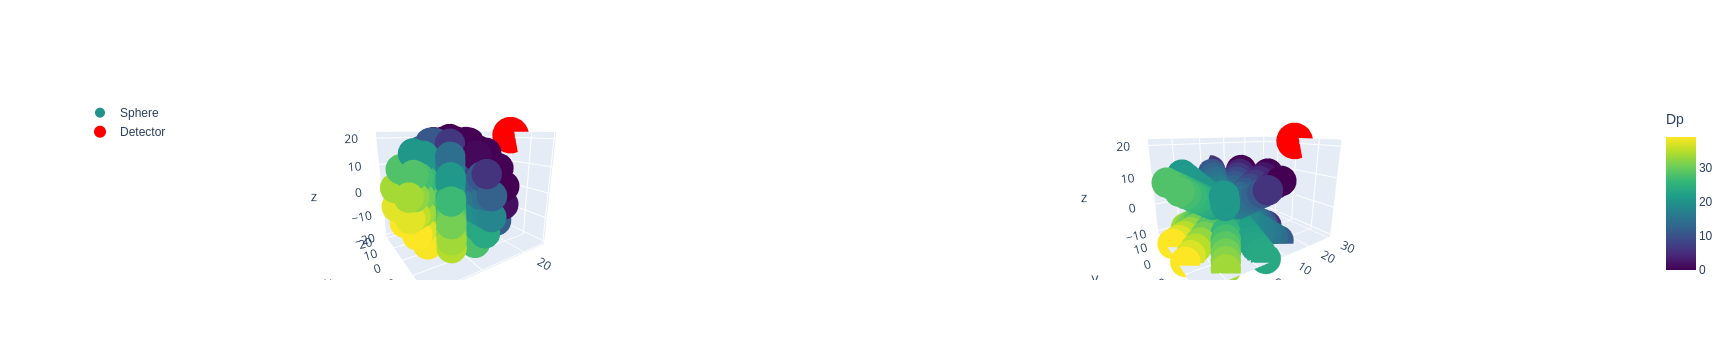

In [10]:
## convert to Cartesian Coordinates 
DDdf['x'] = DDdf['r'] * np.cos(DDdf['θ']) * np.sin(DDdf['φ'])
DDdf['y'] = DDdf['r'] * np.sin(DDdf['θ']) * np.sin(DDdf['φ'])
DDdf['z'] = DDdf['r'] * np.cos(DDdf['φ'])

fig = make_subplots(rows=1, cols=2,
                    specs=[[{'type': 'scatter3d'}, {'type': 'scatter3d'}]],
                    horizontal_spacing = 0.01,
                    vertical_spacing = 0.01)
fig.add_trace(
    go.Scatter3d(x=DDdf['x'], y=DDdf['y'], z=DDdf['z'],
                 mode='markers',
                 name='Sphere',
                 marker=dict(
                             size=10,
                             color=DDdf['dp'],
                             colorscale='Viridis',
                             colorbar=dict(
                                 title='Dp'),
                             opacity=1
    )),
    row=1, col=1)

fig.add_trace(
    go.Scatter3d(x=[x0_near],
                 y=[y0_near],
                 z=[z0_near],
                 name='Detector',
                 mode='markers',
                 marker=dict(
                            size=12,
                            color='red'          
    )),
    row=1, col=1)

# here a desirable slice may be choosen
condition = (DDdf['φ'] == pi/3)|(DDdf['φ'] == 2*pi/3)

DDdf['x'] = DDdf['r'] * np.cos(DDdf['θ']) * np.sin(DDdf['φ'][condition])
DDdf['y'] = DDdf['r'] * np.sin(DDdf['θ']) * np.sin(DDdf['φ'][condition])
DDdf['z'] = DDdf['r'] * np.cos(DDdf['φ'][condition])

fig.add_trace(
    go.Scatter3d(x=DDdf['x'], y=DDdf['y'], z=DDdf['z'],
                 mode='markers',
                 showlegend=False,
                 marker=dict(
                             size=10,
                             color=DDdf['dp'],
                             colorscale='Viridis',
    )),
    row=1, col=2)

fig.add_trace(
    go.Scatter3d(x=[x0_near],
                 y=[y0_near],
                 z=[z0_near],
                 showlegend=False,
                 mode='markers',
                 marker=dict(
                            size=12,
                            color='red'          
    )),
    row=1, col=2)

# choose camera position
fig.layout.scene1.camera.eye=dict(x=-1, y=-1.5, z=0.5)
fig.layout.scene1.xaxis=dict(nticks=5)
fig.layout.scene1.yaxis=dict(nticks=5)
fig.layout.scene1.zaxis=dict(nticks=5)

fig.layout.scene2.camera.eye=dict(x=-1, y=-1.5, z=0.5)
fig.layout.scene2.xaxis=dict(nticks=5)
fig.layout.scene2.yaxis=dict(nticks=5)
fig.layout.scene2.zaxis=dict(nticks=5)

fig.update_layout(legend=dict(yanchor="top", y=1.01, xanchor="left", x=0)) # add legend and show plot


fig.show(renderer='firefox+jupyterlab')
# fig.show(renderer='jupyterlab')